# DSPy 3.0.3 Medical Data Extraction Pipeline

This notebook demonstrates a comprehensive data extraction pipeline using DSPy 3.0.3 to extract structured dichotomous outcomes from medical research papers in markdown format.

## Objective
Extract structured data from medical research markdown  into the target format matching `dichotomous_outcomes.json`.


## 1. Setup and Dependencies


In [112]:
import dspy
import json
import pandas as pd
import numpy as np
import re
import os
from typing import List, Dict, Any, Optional, Tuple
from dataclasses import dataclass
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics.pairwise import cosine_similarity
import warnings
import asyncio
from datetime import datetime
import aiofiles
import traceback

import tiktoken
from sentence_transformers import SentenceTransformer
from dotenv import load_dotenv
import hashlib
from scipy.optimize import linear_sum_assignment
import diskcache as dc

# Suppress warnings
warnings.filterwarnings('ignore')

# Load environment variables
load_dotenv()

# Print DSPy version
print(f"DSPy version: {dspy.__version__}")

DSPy version: 3.0.3


## 2. Configure DSPy Language Model


In [113]:
# Set your API key (uncomment and add your key)
# os.environ["OPENAI_API_KEY"] = "your-api-key-here"

# Configure DSPy with OpenAI GPT-4o-mini for cost efficiency
lm = dspy.LM('gemini/gemini-2.5-pro', max_tokens=20000, temperature=1.0)
dspy.configure(lm=lm)

print("Language model configured successfully")


Language model configured successfully


In [114]:
# Global variables to track processed calls
_processed_hashes = set()
_csv_path = "dspy_history.csv"

def set_log_file(csv_path: str):
    """Set the CSV file path for logging."""
    global _csv_path, _processed_hashes
    _csv_path = csv_path
    
    # Load existing hashes from CSV if it exists
    if Path(csv_path).exists():
        try:
            df = pd.read_csv(csv_path)
            if 'call_hash' in df.columns:
                _processed_hashes = set(df['call_hash'].tolist())
                print(f"Loaded {len(_processed_hashes)} existing records from {csv_path}")
        except Exception as e:
            print(f"Warning: Could not load existing CSV: {e}")
    else:
        print(f"New log file will be created: {csv_path}")

def log_history():
    """Log current DSPy history to CSV. Call this after running DSPy operations."""
    global _processed_hashes, _csv_path
    
    # Get LM from dspy settings
    try:
        lm = dspy.settings.lm
    except:
        print("Error: No LM found in dspy.settings")
        return 0
    
    if not hasattr(lm, 'history') or not lm.history:
        print("No history found in language model")
        return 0
    
    new_records = []
    
    for call_data in lm.history:
        # Generate unique hash
        hash_content = {
            'messages': call_data.get('messages', []),
            'timestamp': call_data.get('timestamp', ''),
            'uuid': call_data.get('uuid', ''),
        }
        call_hash = hashlib.md5(json.dumps(hash_content, sort_keys=True, default=str).encode()).hexdigest()
        
        # Skip if already processed
        if call_hash in _processed_hashes:
            continue
        
        # Extract call info
        messages = call_data.get('messages', [])
        system_msg = next((m.get('content', '') for m in messages if m.get('role') == 'system'), '')
        user_msg = next((m.get('content', '') for m in messages if m.get('role') == 'user'), '')
        
        # Extract response
        response_obj = call_data.get('response', {})
        assistant_response = ""
        if hasattr(response_obj, 'choices') and response_obj.choices:
            assistant_response = response_obj.choices[0].message.content
        
        # Extract usage
        usage = call_data.get('usage', {})
        if isinstance(usage, dict):
            prompt_tokens = usage.get('prompt_tokens', 0)
            completion_tokens = usage.get('completion_tokens', 0) 
            total_tokens = usage.get('total_tokens', 0)
        else:
            prompt_tokens = completion_tokens = total_tokens = 0
        
        record = {
            'call_hash': call_hash,
            'timestamp': call_data.get('timestamp', datetime.now().isoformat()),
            'uuid': call_data.get('uuid', ''),
            'model': call_data.get('model', ''),
            'cost': call_data.get('cost', 0.0),
            'prompt_tokens': prompt_tokens,
            'completion_tokens': completion_tokens,
            'total_tokens': total_tokens,
            'system_msg_length': len(system_msg),
            'user_msg_preview': user_msg[:200] if user_msg else '',
            'response_preview': assistant_response[:200] if assistant_response else '',
            'cache_hit': getattr(response_obj, 'cache_hit', False) if response_obj else False,
            'logged_at': datetime.now().isoformat()
        }
        
        new_records.append(record)
        _processed_hashes.add(call_hash)
    
    if not new_records:
        print("No new records to add")
        return 0
    
    # Save to CSV
    new_df = pd.DataFrame(new_records)
    
    if Path(_csv_path).exists():
        new_df.to_csv(_csv_path, mode='a', header=False, index=False)
    else:
        Path(_csv_path).parent.mkdir(parents=True, exist_ok=True)
        new_df.to_csv(_csv_path, index=False)
    
    print(f"Added {len(new_records)} new records to {_csv_path}")
    return len(new_records)

def show_stats():
    """Show statistics from the logged history."""
    global _csv_path
    
    if not Path(_csv_path).exists():
        print("No history file found")
        return
    
    try:
        df = pd.read_csv(_csv_path)
        
        print(f"\nDSPy History Stats from {_csv_path}:")
        print("=" * 50)
        print(f"Total calls: {len(df)}")
        
        if 'model' in df.columns:
            print(f"Unique models: {df['model'].nunique()}")
            print("Model breakdown:")
            for model, count in df['model'].value_counts().head().items():
                print(f"  {model}: {count} calls")
        
        if 'cost' in df.columns:
            total_cost = df['cost'].sum()
            avg_cost = df['cost'].mean()
            print(f"Total cost: ${total_cost:.4f}")
            print(f"Average cost per call: ${avg_cost:.4f}")
        
        if 'total_tokens' in df.columns:
            total_tokens = df['total_tokens'].sum()
            avg_tokens = df['total_tokens'].mean()
            print(f"Total tokens: {total_tokens:,}")
            print(f"Average tokens per call: {avg_tokens:.1f}")
        
        if 'cache_hit' in df.columns:
            cache_rate = df['cache_hit'].mean() * 100
            print(f"Cache hit rate: {cache_rate:.1f}%")
        
        if 'timestamp' in df.columns:
            print(f"Date range: {df['timestamp'].min()} to {df['timestamp'].max()}")
        
    except Exception as e:
        print(f"Error reading history: {e}")

def view_recent(n=5):
    """View the most recent n logged calls."""
    global _csv_path
    
    if not Path(_csv_path).exists():
        print("No history file found")
        return
    
    try:
        df = pd.read_csv(_csv_path)
        recent = df.tail(n)
        
        print(f"\nMost Recent {n} DSPy Calls:")
        print("=" * 60)
        
        for _, row in recent.iterrows():
            print(f"Time: {row['timestamp']}")
            print(f"Model: {row['model']}")
            print(f"Tokens: {row['total_tokens']} | Cost: ${row['cost']:.4f}")
            print(f"User: {row['user_msg_preview'][:100]}...")
            print(f"Response: {row['response_preview'][:100]}...")
            print("-" * 40)
            
    except Exception as e:
        print(f"Error reading history: {e}")

def clear_cache():
    """Clear the processed hashes cache (will reprocess all history next time)."""
    global _processed_hashes
    _processed_hashes.clear()
    print("Cleared processed hashes cache")

def export_full_history(output_file: str = "full_dspy_history.json"):
    """Export complete DSPy history with full messages to JSON."""
    try:
        lm = dspy.settings.lm
        if hasattr(lm, 'history') and lm.history:
            with open(output_file, 'w') as f:
                json.dump(lm.history, f, indent=2, default=str)
            print(f"Exported full history to {output_file}")
        else:
            print("No history found to export")
    except Exception as e:
        print(f"Error exporting history: {e}")

# Initialize with default file
set_log_file("dspy_history.csv")

print("DSPy History Logger for Notebooks Ready!")
print("Usage:")
print("  set_log_file('my_file.csv')  # Set custom log file")
print("  log_history()                # Log current DSPy history") 
print("  show_stats()                 # Show summary statistics")
print("  view_recent(5)               # View recent 5 calls")
print("  clear_cache()                # Clear processed cache")
print("  export_full_history()        # Export complete history to JSON")

# Cell 1: Set your log file
set_log_file("/nlp/data/karthik9/Sprint1/Dental/Data/csvs/extraction_history.csv")

New log file will be created: dspy_history.csv
DSPy History Logger for Notebooks Ready!
Usage:
  set_log_file('my_file.csv')  # Set custom log file
  log_history()                # Log current DSPy history
  show_stats()                 # Show summary statistics
  view_recent(5)               # View recent 5 calls
  clear_cache()                # Clear processed cache
  export_full_history()        # Export complete history to JSON
Loaded 945 existing records from /nlp/data/karthik9/Sprint1/Dental/Data/csvs/extraction_history.csv


In [115]:
def safe_json_parse(json_string, fallback=None):
    """Robust JSON parser with multiple recovery strategies."""
    if fallback is None:
        fallback = {}
    
    if not json_string or not isinstance(json_string, str):
        return fallback
    
    # Clean markdown fences first
    import re
    json_string = re.sub(r"```[a-zA-Z]*\n?", "", json_string).replace("```", "")
    json_string = json_string.strip()
    
    # Strategy 1: Direct parsing
    try:
        result = json.loads(json_string)
        if isinstance(result, str) and result.strip().startswith(("{", "[")):
            return safe_json_parse(result, fallback)
        return result
    except json.JSONDecodeError:
        pass
    
    # Strategy 2: Clean common issues and handle nested single quotes
    try:
        cleaned = json_string.strip()
        cleaned = cleaned.replace('\n', '\\n').replace('\r', '\\r').replace('\t', '\\t')
        cleaned = re.sub(r',(\s*[}\]])', r'\1', cleaned)
        
        if cleaned.startswith("'") or "': '" in cleaned or "': {'" in cleaned:
            cleaned = cleaned.replace("'", '"')
            cleaned = cleaned.replace('""', '"')
        else:
            cleaned = re.sub(r"'([^']*)':", r'"\1":', cleaned)
            cleaned = re.sub(r":\s*'([^']*)'", r': "\1"', cleaned)
        
        result = safe_json_parse(cleaned)
        if isinstance(result, str) and result.strip().startswith(("{", "[")):
            return safe_json_parse(result, fallback)
        return result
    except (json.JSONDecodeError, AttributeError):
        pass
    
    # Strategy 3: Extract key-value pairs manually
    try:
        data = {}
        for match in re.finditer(r'"([^"]+)":\s*(\d+(?:\.\d+)?)', json_string):
            key, value = match.groups()
            data[key] = float(value) if '.' in value else int(value)
        
        for match in re.finditer(r'"([^"]+)":\s*"([^"]*)"', json_string):
            key, value = match.groups()
            data[key] = value
        
        for match in re.finditer(r'"([^"]+)":\s*(true|false)', json_string):
            key, value = match.groups()
            data[key] = value == 'true'
        
        if data:
            return data
    except:
        pass
    
    return fallback


## 3. Data Loading and Exploration


In [116]:
# Load source file
source_file = "/nlp/data/karthik9/Sprint1/Dental/Data/acute_pain_mds/2216_Moller_md/2216_Moller_md.json"
target_file = "/nlp/data/karthik9/Sprint1/Dental/Data/jsons/dichotomous_outcomes.json"

with open(source_file, 'r') as f:
    source_data = json.load(f)

with open(target_file, 'r') as f:
    target_data = json.load(f)

print(source_data.keys())

# Extract markdown content
markdown_content = source_data['marker']['markdown']

# Use OpenAI tokenizer (cl100k_base is the same one GPT-4/4o/5 use)
encoding = tiktoken.get_encoding("cl100k_base")
tokens = encoding.encode(markdown_content)

print(f"Markdown content length: {len(markdown_content)} characters")
print(f"Token count: {len(tokens)}")
print(f"Target data contains {len(target_data)} records")

dict_keys(['id', 'pdf_path', 'unique_filename', 'marker', 'status', 'processing_timestamp'])
Markdown content length: 41730 characters
Token count: 9347
Target data contains 1691 records


In [117]:
# Filter target data for  study to understand expected output
one_study_records = [record for record in target_data if record.get('filename') == '2216_Moller']
print(f"Found {len(one_study_records)} records in target data")

# Show example record structure
if one_study_records:
    print("\nExample target record structure:")
    for key, value in one_study_records[0].items():
        print(f"{key}: {value}")


Found 60 records in target data

Example target record structure:
Ref_ID: 2216
First_Author: Moller
Trial_Name: 
Population: 2
Intervention_Code: 8
Intervention_Description: Acetaminophen Effervescent 1000mg
Outcome_Type: 2
Outcome_Other_Specify: 
Follow_Up_Time: 4 hours
N_Analyzed: 60
Adverse_Effect_Specify: 
Adverse_Effects_All_Study: 
N_Events_Number: 51
N_Events_Percentage: 85
Comments: 
filename: 2216_Moller


## 4. DSPy Signature Definitions

We'll define specialized signatures for each extraction task:


In [118]:
class ExtractStudyMetadata(dspy.Signature):
    """Extract basic study metadata from medical research paper markdown.
    
    This extracts core identifying information about the dental pain management study.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")

    first_author: str = dspy.OutputField(
        desc="Last name of the first author (e.g., 'Cooper'). Extract only the surname."
    )
    
    population_code: str = dspy.OutputField(
        desc="Numeric code representing the study population type. Codes: 1=simple tooth extraction, 2=surgical tooth extraction (third molar/wisdom teeth), 3=surgical tooth extraction (other teeth), 4=pulpitis or its complications. Can be multiple codes separated by commas (e.g., '2, 3')"
    )
    


class ExtractInterventions(dspy.Signature):
    """Extract intervention details from medical research paper markdown.
    
    This extracts information about pain management interventions used in dental studies.
    Focus on medication types, dosages, and participant counts.
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper")
    
    interventions_json: str = dspy.OutputField(
        desc="""JSON string containing list of interventions. Each intervention object must have:
        - intervention_code (integer): Numeric code 1-11 where:
          1=Ibuprofen 200-400mg + Acetaminophen 500-1000mg
          2=Oxycodone 5mg or Codeine 60mg  
          3=Acetaminophen 650mg + Oxycodone 10mg
          4=Ibuprofen 200mg + Hydrocodone 5mg
          5=Hydrocodone 5mg + Acetaminophen 300-325mg
          6=Ibuprofen 400mg (fast acting or acid)
          7=Tramadol 37.5mg + Acetaminophen 325mg
          8=Acetaminophen 500-1000mg
          9=Acetaminophen 600-650mg + Codeine 60mg
          10=Naproxen 400-440mg
          11=Placebo/NA (If its not mentioned as a placebo, then it is NA)
          #12=OTHER
        - intervention_description (string): Full description with medication name and exact dose (e.g., "Ibuprofen 400mg", "Naproxen sodium 440mg")
        - n_analyzed (integer): Number of participants analyzed for this intervention group
        
        Example: [{"intervention_code": 6, "intervention_description": "Ibuprofen 400mg", "n_analyzed": 40}]"""
    )


class ExtractAllOutcomes(dspy.Signature):
    """Extract ALL outcomes from medical research paper for systematic review.
    
    This implements COMPLETE DATA CAPTURE methodology - extract every data point
    including rescue analgesia, adverse events, and other outcomes at all time points.
    Focus on dichotomous outcomes from ALL data sources: main text, figures, tables,
    and supplementary materials. Include zero-event outcomes (0/N patients).
    """
    
    markdown_content: str = dspy.InputField(desc="Full markdown content of the medical research paper including supplementary materials")
    intervention_description: str = dspy.InputField(desc="Specific intervention to extract outcomes for (e.g., 'Ibuprofen 400mg', 'Placebo')")
    
    all_outcomes_json: str = dspy.OutputField(
        desc="""JSON string containing list of ALL outcomes for the specified intervention. Each outcome object must have:
        
        MANDATORY FIELDS FOR ALL OUTCOMES:
        - outcome_type (integer): Outcome type code where:
          1=Rescue analgesia at 6 hours
          2=Rescue analgesia at 4 hours  
          4=Rescue analgesia for pulpitis population
          5=Adverse effects (nausea, vomiting, drowsiness, dizziness, headache, etc.)
          6=Other outcomes (pain relief, time to onset, etc.)
        - follow_up_time (string): Exact time point when outcome was measured (e.g., "6 hours", "24hrs", "4 hours", "7 days")
        - n_analyzed (integer): Number of participants analyzed for this specific outcome
        - n_events_number (integer): Number of patients who experienced this outcome
        - n_events_percentage (float): Percentage of patients who experienced this outcome (e.g., 17.5, 0.6, 2.4, 0.0)
        
        CONDITIONAL FIELDS:
        - adverse_effect_specify (string): Specific adverse effect name if outcome_type=5 (e.g., "Drowsiness (sleepy, tired)", "Paraesthesia oral", "Vomiting"). Use "NA" if outcome_type≠5
        - other_outcome_specify (string): Detailed description if outcome_type=6 (e.g., "Time to meaningful pain relief", "Pain intensity difference"). Use "NA" if outcome_type≠6
        - adverse_effects_all_study (string): List of all adverse effects if not reported per study arm, or "NA" if reported per arm
        
        DOCUMENTATION FIELDS:
        - extraction_notes (string): Technical documentation including data source ("From Table 2", "From Figure 5", "From Supplementary Table 3"), extraction method ("Direct from table", "Interpreted from Kaplan-Meier curve"), and population used ("Per-protocol population", "Safety population", "ITT population")
        - comments (string): Study-specific information including single vs multiple dose design, surgical techniques mentioned, methodological features, dropout rates, calculation details
        
        EXTRACTION REQUIREMENTS:
        - Extract EVERY outcome reported, including zero-event outcomes (0/N)
        - Create separate entries for each time point assessment
        - Include outcomes from ALL data sources (main text, figures, supplements)
        - Use appropriate analysis populations (efficacy vs safety)
        - Document any calculations or interpretations performed
        
        Example: [
          {"outcome_type": 1, "follow_up_time": "6 hours", "n_analyzed": 40, "n_events_number": 15, "n_events_percentage": 37.5, "adverse_effect_specify": "NA", "other_outcome_specify": "NA", "adverse_effects_all_study": "NA", "extraction_notes": "From Table 3, per-protocol population", "comments": "single dose study with overnight monitoring"},
          {"outcome_type": 5, "follow_up_time": "24 hours", "n_analyzed": 40, "n_events_number": 7, "n_events_percentage": 17.5, "adverse_effect_specify": "Drowsiness (sleepy, tired)", "other_outcome_specify": "NA", "adverse_effects_all_study": "NA", "extraction_notes": "From safety table, safety population", "comments": "mild to moderate severity"}
        ]"""
    )


class StructureComprehensiveOutcome(dspy.Signature):
    """Structure extracted data into the final comprehensive dichotomous outcome format.
    
    This combines study metadata, intervention details, and any outcome data (rescue analgesia,
    adverse events, or other outcomes) into the standardized format used for systematic review
    and meta-analysis. Each record represents one outcome for one intervention in one study.
    """
    
    study_metadata_json: str = dspy.InputField(desc="Study metadata as JSON string with first_author,  population_code")
    intervention_json: str = dspy.InputField(desc="Single intervention details as JSON string with intervention_code, intervention_description, n_analyzed")
    outcome_json: str = dspy.InputField(desc="Single outcome details as JSON string with all outcome fields including outcome_type, follow_up_time, n_events_number, etc.")
    
    structured_record_json: str = dspy.OutputField(
        desc="""Complete structured record as JSON string with exactly these fields:
        - First_Author (string): First author last name (e.g., "Cooper")
        - Population (integer): Population code (1-4)
        - Intervention_Code (integer): Intervention code (1-11)
        - Intervention_Description (string): Full intervention description with dose
        - Outcome_Type (integer): Outcome type (1=rescue analgesia 6h, 2=rescue analgesia 4h, 4=rescue analgesia pulpitis, 5=adverse effects, 6=other)
        - Outcome_Other_Specify (string): Detailed outcome description for type 6, or empty string for other types
        - Follow_Up_Time (string): Time point (e.g., "24hrs", "6 hours")
        - N_Analyzed (integer): Number of participants analyzed
        - Adverse_Effect_Specify (string): Specific adverse effect name for type 5, or empty string for other types
        - Adverse_Effects_All_Study (string): All study adverse effects if not reported per arm, or empty string
        - N_Events_Number (integer): Number of patients with this outcome
        - N_Events_Percentage (float): Percentage of patients with this outcome
        - Comments (string): Study-specific methodology, design notes, and extraction details
        
        FIELD MAPPING RULES:
        - For outcome_type 1,2,4 (rescue analgesia): Adverse_Effect_Specify="" and Outcome_Other_Specify=""
        - For outcome_type 5 (adverse effects): Outcome_Other_Specify="" and Adverse_Effect_Specify=specific adverse event name
        - For outcome_type 6 (other outcomes): Adverse_Effect_Specify="" and Outcome_Other_Specify=detailed outcome description
        - Always include extraction methodology and data source information in Comments
        - Ensure mathematical validation: (N_Events_Number/N_Analyzed)*100 = N_Events_Percentage
        - Use appropriate analysis populations (efficacy vs safety) based on outcome type
        
        Example: {"First_Author": "Cooper",  "Population": 2, "Intervention_Code": 10, "Intervention_Description": "Naproxen sodium 440mg", "Outcome_Type": 5, "Outcome_Other_Specify": "", "Follow_Up_Time": "24hrs", "N_Analyzed": 166, "Adverse_Effect_Specify": "Paraesthesia oral", "Adverse_Effects_All_Study": "", "N_Events_Number": 1, "N_Events_Percentage": 0.6, "Comments": "extracted from supplementary table 3, safety population, single dose study"}"""
    )

## 5. DSPy Module Implementation

Now we'll create DSPy modules that use these signatures with reasoning patterns:


In [119]:
class AsyncStudyMetadataExtractor(dspy.Module):
    """Async module to extract study metadata using chain of thought reasoning."""
    
    def __init__(self):
        super().__init__()
        self.extract_metadata = dspy.ChainOfThought(ExtractStudyMetadata)
    
    async def __call__(self, markdown_content: str) -> Dict[str, Any]:
        """Async call method that runs DSPy call in thread pool."""
        loop = asyncio.get_running_loop()
        
        def _extract():
            return self.extract_metadata(markdown_content=markdown_content)
        
        # Run DSPy call in thread pool to avoid blocking event loop
        result = await loop.run_in_executor(None, _extract)
        
        return {
            "first_author": result.first_author,
            "population_code": result.population_code
        }
    
    def forward_sync(self, markdown_content: str) -> Dict[str, Any]:
        """Fallback sync method for backwards compatibility."""
        result = self.extract_metadata(markdown_content=markdown_content)
        return {
            "first_author": result.first_author,
            "population_code": result.population_code
        }


class AsyncInterventionExtractor(dspy.Module):
    """Async module to extract intervention details."""
    
    def __init__(self):
        super().__init__()
        self.extract_interventions = dspy.ChainOfThought(ExtractInterventions)
    
    async def __call__(self, markdown_content: str) -> List[Dict[str, Any]]:
        """Async call method with error handling."""
        loop = asyncio.get_running_loop()
        
        def _extract():
            return self.extract_interventions(markdown_content=markdown_content)
        
        try:
            result = await loop.run_in_executor(None, _extract)
            return safe_json_parse(result.interventions_json)
        except json.JSONDecodeError as e:
            print(f"Error parsing interventions JSON: {e}, returning empty list")
            return []
        except Exception as e:
            print(f"Error in intervention extraction: {e}, returning empty list")
            return []
    
    def forward_sync(self, markdown_content: str) -> List[Dict[str, Any]]:
        """Fallback sync method."""
        result = self.extract_interventions(markdown_content=markdown_content)
        try:
            return safe_json_parse(result.interventions_json)
        except json.JSONDecodeError:
            print("Error parsing interventions JSON, returning empty list")
            return []


class AsyncOutcomeExtractor(dspy.Module):
    """Async module to extract all outcomes for a specific intervention."""
    
    def __init__(self):
        super().__init__()
        self.extract_all_outcomes = dspy.ChainOfThought(ExtractAllOutcomes)
    
    async def __call__(self, markdown_content: str, intervention_description: str) -> List[Dict[str, Any]]:
        """Async call method with robust error handling."""
        loop = asyncio.get_running_loop()
        
        def _extract():
            return self.extract_all_outcomes(
                markdown_content=markdown_content,
                intervention_description=intervention_description
            )
        
        try:
            result = await loop.run_in_executor(None, _extract)
            return safe_json_parse(result.all_outcomes_json)
        except json.JSONDecodeError as e:
            print(f"Error parsing outcomes JSON for '{intervention_description}': {e}")
            return []
        except Exception as e:
            print(f"Error in outcome extraction for '{intervention_description}': {e}")
            return []
    
    def forward_sync(self, markdown_content: str, intervention_description: str) -> List[Dict[str, Any]]:
        """Fallback sync method."""
        result = self.extract_all_outcomes(
            markdown_content=markdown_content,
            intervention_description=intervention_description
        )
        try:
            return safe_json_parse(result.all_outcomes_json)
        except json.JSONDecodeError:
            print("Error parsing outcomes JSON, returning empty list")
            return []


class AsyncDataStructurer(dspy.Module):
    """Async module to structure data into final format."""
    
    def __init__(self):
        super().__init__()
        self.structure_data = dspy.ChainOfThought(StructureComprehensiveOutcome)
    
    async def __call__(self, study_metadata: Dict, intervention: Dict, outcome: Dict) -> Dict[str, Any]:
        """Async call method with comprehensive error handling."""
        loop = asyncio.get_running_loop()
        
        def _structure():
            return self.structure_data(
                study_metadata_json=json.dumps(study_metadata),
                intervention_json=json.dumps(intervention),
                outcome_json=json.dumps(outcome)
            )
        
        try:
            result = await loop.run_in_executor(None, _structure)
            return safe_json_parse(result.structured_record_json)
        except json.JSONDecodeError as e:
            print(f"Error parsing structured record JSON: {e}, using fallback")
            return self._create_fallback_record(study_metadata, intervention, outcome)
        except Exception as e:
            print(f"Error in data structuring: {e}, using fallback")
            return self._create_fallback_record(study_metadata, intervention, outcome)
    
    def _create_fallback_record(self, study_metadata: Dict, intervention: Dict, outcome: Dict) -> Dict[str, Any]:
        """Create fallback structured record when DSPy fails."""
        return {
            "First_Author": study_metadata.get("first_author", ""),
            "Population": study_metadata.get("population_code", ""),
            "Intervention_Code": intervention.get("intervention_code", ""),
            "Intervention_Description": intervention.get("intervention_description", ""),
            "Outcome_Type": outcome.get("outcome_type", 5),
            "Outcome_Other_Specify": outcome.get("other_outcome_specify", ""),
            "Follow_Up_Time": outcome.get("follow_up_time", ""),
            "N_Analyzed": intervention.get("n_analyzed", ""),
            "Adverse_Effect_Specify": outcome.get("adverse_effect_specify", ""),
            "Adverse_Effects_All_Study": outcome.get("adverse_effects_all_study", ""),
            "N_Events_Number": outcome.get("n_events_number", ""),
            "N_Events_Percentage": outcome.get("n_events_percentage", ""),
            "Comments": f"{outcome.get('extraction_notes', '')} {outcome.get('comments', '')}".strip(),
        }
    
    def forward_sync(self, study_metadata: Dict, intervention: Dict, outcome: Dict) -> Dict[str, Any]:
        """Fallback sync method."""
        result = self.structure_data(
            study_metadata_json=json.dumps(study_metadata),
            intervention_json=json.dumps(intervention),
            outcome_json=json.dumps(outcome)
        )
        try:
            return safe_json_parse(result.structured_record_json)
        except json.JSONDecodeError:
            print("Error parsing structured record JSON, returning basic structure")
            return self._create_fallback_record(study_metadata, intervention, outcome)


# Batch processing wrapper for efficient concurrent execution
class AsyncBatchProcessor:
    """Handles batch processing of multiple operations with concurrency control."""
    
    def __init__(self, max_concurrent: int = 5):
        self.semaphore = asyncio.Semaphore(max_concurrent)
    
    async def process_interventions_batch(self, intervention_extractor: AsyncInterventionExtractor, 
                                        markdown_contents: List[str]) -> List[List[Dict[str, Any]]]:
        """Process multiple markdown contents concurrently for interventions."""
        
        async def _extract_with_semaphore(content: str):
            async with self.semaphore:
                return await intervention_extractor.forward(content)
        
        tasks = [_extract_with_semaphore(content) for content in markdown_contents]
        return await asyncio.gather(*tasks)
    
    async def process_outcomes_batch(self, outcome_extractor: AsyncOutcomeExtractor,
                                   markdown_content: str, 
                                   intervention_descriptions: List[str]) -> List[List[Dict[str, Any]]]:
        """Process multiple interventions concurrently for outcomes."""
        
        async def _extract_with_semaphore(intervention_desc: str):
            async with self.semaphore:
                return await outcome_extractor.forward(markdown_content, intervention_desc)
        
        tasks = [_extract_with_semaphore(desc) for desc in intervention_descriptions]
        return await asyncio.gather(*tasks)


# Factory function to create all async modules
def create_async_modules(max_concurrent: int = 5) -> Dict[str, Any]:
    """Factory function to create all async modules with shared configuration."""
    return {
        'metadata_extractor': AsyncStudyMetadataExtractor(),
        'intervention_extractor': AsyncInterventionExtractor(),
        'outcome_extractor': AsyncOutcomeExtractor(),
        'data_structurer': AsyncDataStructurer(),
        'batch_processor': AsyncBatchProcessor(max_concurrent=max_concurrent)
    }

print("Async DSPy modules defined successfully")

Async DSPy modules defined successfully


## 6. Complete Extraction Pipeline


In [120]:
class AsyncMedicalDataExtractionPipeline(dspy.Module):
    """Complete async pipeline for extracting structured data from medical research papers."""
    
    def __init__(self, max_concurrent: int = 5):
        super().__init__()
        self.metadata_extractor = AsyncStudyMetadataExtractor()
        self.intervention_extractor = AsyncInterventionExtractor()
        self.outcome_extractor = AsyncOutcomeExtractor()
        self.data_structurer = AsyncDataStructurer()
        self.semaphore = asyncio.Semaphore(max_concurrent)
    
    async def forward(self, markdown_content: str):
        """Extract all structured records from markdown content asynchronously."""
        
        # Step 1 & 2: Extract metadata and interventions concurrently
        print("Extracting metadata and interventions concurrently...")
        
        metadata_task = self.metadata_extractor(markdown_content)
        interventions_task = self.intervention_extractor(markdown_content)
        
        study_metadata, interventions = await asyncio.gather(metadata_task, interventions_task)
        
        print(f"Study metadata: {study_metadata}")
        print(f"Found {len(interventions)} interventions")
        
        # Step 3: Process all interventions concurrently
        all_records = []
        
        if interventions:
            outcome_tasks = []
            for intervention in interventions:
                task = self._process_intervention_outcomes(
                    markdown_content, study_metadata, intervention
                )
                outcome_tasks.append(task)
            
            # Gather all intervention results
            intervention_results = await asyncio.gather(*outcome_tasks)
            
            # Flatten results
            for records in intervention_results:
                all_records.extend(records)
        
        print(f"Total records extracted: {len(all_records)}")
        return dspy.Prediction(extracted_records=all_records)
    
    async def _process_intervention_outcomes(self, markdown_content: str, 
                                           study_metadata: Dict, intervention: Dict) -> List[Dict]:
        """Process outcomes for a single intervention with semaphore control."""
        async with self.semaphore:
            intervention_desc = intervention.get('intervention_description', '')
            print(f"Processing intervention: {intervention_desc}")
            
            outcomes = await self.outcome_extractor(markdown_content, intervention_desc)
            print(f"Found {len(outcomes)} outcomes for {intervention_desc}")
            
            # Structure all outcomes for this intervention concurrently
            if outcomes:
                structure_tasks = [
                    self.data_structurer(study_metadata, intervention, outcome)
                    for outcome in outcomes
                ]
                structured_records = await asyncio.gather(*structure_tasks)
                return structured_records
            
            return []
    
    def _generate_output_filename(self, source_file_path: str) -> str:
        """Generate output filename from source filename."""
        source_path = Path(source_file_path)
        source_name = source_path.stem
        
        if source_name.endswith('_md'):
            output_name = source_name[:-3] + '_do'
        else:
            output_name = source_name + '_do'
        
        return output_name + '.json'
    
    async def save_extracted_results(self, extracted_records: List[Dict], 
                                   source_file_path: str, 
                                   output_dir: str = None, 
                                   override: bool = False) -> str:
        """Save extracted results to JSON file asynchronously."""
        try:
            output_filename = self._generate_output_filename(source_file_path)
            
            if output_dir is None:
                output_dir = Path(source_file_path).parent
            else:
                output_dir = Path(output_dir)
            
            output_dir.mkdir(parents=True, exist_ok=True)
            output_path = output_dir / output_filename
            
            if output_path.exists() and not override:
                print(f"Output file already exists: {output_path}")
                print("Use override=True to overwrite, or file will be skipped")
                return None
            
            save_data = {
                "metadata": {
                    "source_file": str(source_file_path),
                    "extraction_timestamp": datetime.now().isoformat(),
                    "total_records": len(extracted_records),
                    "pipeline_version": "DSPy_Async_1.0"
                },
                "extracted_records": extracted_records
            }
            
            async with aiofiles.open(output_path, 'w', encoding='utf-8') as f:
                await f.write(json.dumps(save_data, indent=2, ensure_ascii=False))
            
            print(f"Successfully saved {len(extracted_records)} records to: {output_path}")
            return str(output_path)
            
        except Exception as e:
            print(f"Error saving results: {e}")
            return None
    
    async def run_and_save(self, markdown_content: str, source_file_path: str, 
                          output_dir: str = None, override: bool = False):
        """Run pipeline and save results asynchronously."""
        prediction = await self.forward(markdown_content)
        await self.save_extracted_results(
            prediction.extracted_records, source_file_path, output_dir, override
        )
        return prediction

class AsyncBatchPipeline:
    """Batch processor for handling multiple files concurrently."""
    
    def __init__(self, max_concurrent_files: int = 3, max_concurrent_per_file: int = 5):
        self.file_semaphore = asyncio.Semaphore(max_concurrent_files)
        self.max_concurrent_per_file = max_concurrent_per_file
    
    async def process_single_file(self, file_path: str, markdown_content: str, 
                                output_dir: str = None, override: bool = False):
        """Process a single file with semaphore control."""
        async with self.file_semaphore:
            pipeline = AsyncMedicalDataExtractionPipeline(self.max_concurrent_per_file)
            print(f"Processing file: {Path(file_path).name}")
            return await pipeline.run_and_save(markdown_content, file_path, output_dir, override)
    
    async def process_files_batch(self, file_data: List[Dict], output_dir: str = None, 
                                override: bool = False):
        """Process multiple files concurrently.
        
        Args:
            file_data: List of dicts with 'file_path' and 'markdown_content' keys
            output_dir: Output directory for results
            override: Whether to overwrite existing files
        """
        print(f"Starting batch processing of {len(file_data)} files...")
        
        tasks = [
            self.process_single_file(
                item['file_path'], 
                item['markdown_content'], 
                output_dir, 
                override
            ) 
            for item in file_data
        ]
        
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        # Count successful vs failed
        successful = sum(1 for r in results if not isinstance(r, Exception))
        failed = len(results) - successful
        
        print(f"Batch processing complete: {successful} successful, {failed} failed")
        return results

print("Async extraction pipeline with batch processing defined successfully")

Async extraction pipeline with batch processing defined successfully


## 7. Evaluation Setup


### The 4 Core Outcomes in Classification

When evaluating a system’s predictions against the **ground truth**, each result falls into one of four categories:

### 1. **True Positive (TP)**
- System says **“Yes”**
- Ground truth is **“Yes”**
- ✅ Correct detection  
- **Example:** System extracts `First_Author = Cooper`, and ground truth really has `Cooper`.



### 2. **False Positive (FP)**
- System says **“Yes”**
- Ground truth is **“No”**
- ❌ Wrong detection (system “hallucinated”)  
- **Example:** System extracts `First_Author = Jones`, but ground truth has `Smith`.



### 3. **True Negative (TN)**
- System says **“No”**
- Ground truth is **“No”**
- ✅ Correct rejection  
- **Example:** Ground truth has no `Adverse_Effect_Specify`, and system also leaves it empty.



### 4. **False Negative (FN)**
- System says **“No”**
- Ground truth is **“Yes”**
- ❌ Missed detection (system failed to extract)  
- **Example:** Ground truth has `Trial_Name = MOLAR`, but system extracts nothing (or extracts wrong value).



### In `MedicalExtractionEvaluator` Context

- **TP (True Positive)** → A field value was extracted **and** it matched the ground truth.  
- **FP (False Positive)** → A field value was extracted, but it was **wrong** (mismatch) or **extra** (system filled something that shouldn’t exist).  
- **FN (False Negative)** → A ground-truth field existed, but the system didn’t produce it (missing record or missing field).  
- **TN (True Negative)** → Neither system nor ground truth had a value for a field.  

**Note:** TNs are **not explicitly tracked** in the evaluator, because in information extraction tasks the number of “true negatives” is usually very large and not informative. This is common in IR/NLP evaluation — most focus only on TP, FP, FN.


In [121]:
class AsyncMedicalExtractionEvaluator:
    """Async evaluator for medical data extraction with semantic matching and caching."""
    
    def __init__(self, use_semantic=True, semantic_threshold=0.8, max_concurrent=10):
        self.required_fields = [
            'First_Author', 'Population', 'Intervention_Code', 'Intervention_Description', 
            'Outcome_Type', 'Follow_Up_Time', 'N_Analyzed', 'Adverse_Effect_Specify',
            'N_Events_Number', 'N_Events_Percentage', 'Comments'
        ]
        
        self.use_semantic = use_semantic
        self.semantic_threshold = semantic_threshold
        self.semaphore = asyncio.Semaphore(max_concurrent)
        
        # Caches
        self._matching_cache = {}
        self._embedding_cache = {}
        
        if self.use_semantic:
            self.semantic_model = SentenceTransformer('all-MiniLM-L6-v2')
            self.semantic_fields = ['Intervention_Description', 'Adverse_Effect_Specify', 'Follow_Up_Time']
            self.exact_fields = ['First_Author', 'Population', 'Intervention_Code', 'Outcome_Type', 
                               'N_Analyzed', 'N_Events_Number', 'N_Events_Percentage']
    
    async def _get_embedding(self, text: str):
        """Get embedding for text with async caching."""
        if text in self._embedding_cache:
            return self._embedding_cache[text]
        
        # Run embedding generation in thread pool
        loop = asyncio.get_running_loop()
        embedding = await loop.run_in_executor(None, self.semantic_model.encode, text)
        
        self._embedding_cache[text] = embedding
        return embedding
    
    async def semantic_similarity(self, text1: str, text2: str) -> float:
        """Calculate semantic similarity asynchronously."""
        if not self.use_semantic or not text1.strip() or not text2.strip():
            return 1.0 if text1.strip() == text2.strip() else 0.0
        
        # Get embeddings concurrently
        embedding1_task = self._get_embedding(text1)
        embedding2_task = self._get_embedding(text2)
        
        embedding1, embedding2 = await asyncio.gather(embedding1_task, embedding2_task)
        
        # Calculate similarity in thread pool
        loop = asyncio.get_running_loop()
        similarity = await loop.run_in_executor(
            None, lambda: cosine_similarity([embedding1], [embedding2])[0][0]
        )
        
        return float(similarity)
    
    async def field_match_score(self, extracted_value: Any, ground_truth_value: Any, field_name: str) -> float:
        """Calculate field-level match score asynchronously."""
        ext_val = str(extracted_value).strip() if extracted_value is not None else ""
        gt_val = str(ground_truth_value).strip() if ground_truth_value is not None else ""
        
        if not self.use_semantic or field_name in self.exact_fields:
            return 1.0 if ext_val.lower() == gt_val.lower() else 0.0
        
        if field_name in self.semantic_fields:
            if not ext_val and not gt_val:
                return 1.0
            if not ext_val or not gt_val:
                return 0.0
            
            similarity = await self.semantic_similarity(ext_val, gt_val)
            return 1.0 if similarity >= self.semantic_threshold else 0.0
        
        return 1.0 if ext_val.lower() == gt_val.lower() else 0.0
    
    async def calculate_record_similarity(self, extracted_record: Dict, ground_truth_record: Dict) -> float:
        """Calculate similarity between two records asynchronously."""
        async with self.semaphore:
            # Gather all field comparisons concurrently
            field_tasks = []
            for field in self.required_fields:
                if field in extracted_record and field in ground_truth_record:
                    task = self.field_match_score(
                        extracted_record[field], 
                        ground_truth_record[field], 
                        field
                    )
                    field_tasks.append(task)
            
            if not field_tasks:
                return 0.0
            
            match_scores = await asyncio.gather(*field_tasks)
            return sum(match_scores) / len(match_scores)
    
    async def _compute_similarity_matrix(self, extracted_records: List[Dict], ground_truth_records: List[Dict]):
        """Compute similarity matrix asynchronously."""
        n_extracted = len(extracted_records)
        n_ground_truth = len(ground_truth_records)
        
        # Create all similarity computation tasks
        tasks = []
        for i in range(n_extracted):
            for j in range(n_ground_truth):
                task = self.calculate_record_similarity(extracted_records[i], ground_truth_records[j])
                tasks.append((i, j, task))
        
        # Execute all similarity computations concurrently
        results = await asyncio.gather(*[task for _, _, task in tasks])
        
        # Build similarity matrix
        similarity_matrix = np.zeros((n_extracted, n_ground_truth))
        for idx, (i, j, _) in enumerate(tasks):
            similarity_matrix[i][j] = results[idx]
        
        return similarity_matrix
    
    async def hungarian_matching(self, extracted_records: List[Dict], ground_truth_records: List[Dict]) -> List[Tuple[int, int, float]]:
        """Compute Hungarian matching asynchronously with caching."""
        cache_key = f"{len(extracted_records)}_{len(ground_truth_records)}_{hash(str(extracted_records) + str(ground_truth_records))}"
        
        if cache_key in self._matching_cache:
            return self._matching_cache[cache_key]
        
        if not extracted_records or not ground_truth_records:
            return []
        
        # Compute similarity matrix asynchronously
        similarity_matrix = await self._compute_similarity_matrix(extracted_records, ground_truth_records)
        
        # Apply Hungarian algorithm in thread pool
        loop = asyncio.get_running_loop()
        cost_matrix = 1.0 - similarity_matrix
        
        # Pad matrix to square if needed
        n_extracted, n_ground_truth = similarity_matrix.shape
        max_size = max(n_extracted, n_ground_truth)
        if max_size > max(n_extracted, n_ground_truth):
            padded_cost = np.ones((max_size, max_size))
            padded_cost[:n_extracted, :n_ground_truth] = cost_matrix
            cost_matrix = padded_cost
        
        row_indices, col_indices = await loop.run_in_executor(None, linear_sum_assignment, cost_matrix)
        
        # Extract valid matches
        matches = []
        for i, j in zip(row_indices, col_indices):
            if i < n_extracted and j < n_ground_truth:
                similarity = similarity_matrix[i][j]
                if similarity > 0.0:
                    matches.append((i, j, similarity))
        
        # Cache results
        self._matching_cache[cache_key] = matches
        return matches
    
    async def evaluate_record_metrics(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> Dict[str, float]:
        """Calculate record-level metrics asynchronously."""
        matches = await self.hungarian_matching(extracted_records, ground_truth)
        valid_matches = [match for match in matches if match[2] >= 0.5]
        
        true_positives = len(valid_matches)
        false_positives = len(extracted_records) - true_positives
        false_negatives = len(ground_truth) - true_positives
        
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
        
        return {
            'precision': precision, 'recall': recall, 'f1': f1,
            'TP': true_positives, 'FP': false_positives, 'FN': false_negatives
        }
    
    def evaluate_completeness(self, extracted_records: List[Dict]) -> float:
        """Evaluate field completeness (synchronous)."""
        if not extracted_records:
            return 0.0
        
        total_fields = len(self.required_fields) * len(extracted_records)
        filled_fields = sum(
            1 for record in extracted_records 
            for field in self.required_fields 
            if field in record and record[field] is not None and str(record[field]).strip()
        )
        
        return filled_fields / total_fields if total_fields > 0 else 0.0
    
    async def evaluate_accuracy(self, extracted_records: List[Dict], ground_truth: List[Dict]) -> Dict[str, float]:
        """Evaluate extraction accuracy asynchronously."""
        if not extracted_records or not ground_truth:
            return {"precision": 0.0, "recall": 0.0, "f1": 0.0}
        
        record_metrics = await self.evaluate_record_metrics(extracted_records, ground_truth)
        
        return {
            **record_metrics,
            "completeness": self.evaluate_completeness(extracted_records)
        }
    
    async def evaluate(self, extracted_records: List[Dict], ground_truth: List[Dict] = None) -> Dict[str, Any]:
        """Complete evaluation asynchronously."""
        results = {
            "num_extracted": len(extracted_records),
            "completeness": self.evaluate_completeness(extracted_records),
            "semantic_enabled": self.use_semantic,
            "semantic_threshold": self.semantic_threshold if self.use_semantic else None
        }
        
        if ground_truth:
            accuracy_results = await self.evaluate_accuracy(extracted_records, ground_truth)
            results.update(accuracy_results)
            results["num_ground_truth"] = len(ground_truth)
        
        return results
    
    async def save_evaluation_to_csv(self, baseline_results: List[Dict], ground_truth: List[Dict], 
                                   source_file: str, csv_dir: str = "/nlp/data/karthik9/Sprint1/Dental/Data/csvs", 
                                   override: bool = False):
        """Save evaluation results to CSV asynchronously."""
        Path(csv_dir).mkdir(parents=True, exist_ok=True)
        csv_path = Path(csv_dir) / "do_evaluation_results.csv"
        
        # Get matching results
        matches = await self.hungarian_matching(baseline_results, ground_truth)
        
        # Prepare data rows
        rows = []
        matched_gt_indices = set()
        matched_ext_indices = set()
        timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
        
        # Add matched pairs (TP)
        for ext_idx, gt_idx, score in matches:
            if score >= 0.5:
                matched_gt_indices.add(gt_idx)
                matched_ext_indices.add(ext_idx)
                
                for data_type, record_list, idx in [
                    ('ground_truth', ground_truth, gt_idx),
                    ('extracted', baseline_results, ext_idx)
                ]:
                    row = record_list[idx].copy()
                    row.update({
                        'data_type': data_type, 'source_file': source_file,
                        'match_score': score, 'pair_id': f"{source_file}_{gt_idx}",
                        'classification': 'TP', 'timestamp': timestamp
                    })
                    rows.append(row)
        
        # Add unmatched ground truth (FN)
        for gt_idx, gt_record in enumerate(ground_truth):
            if gt_idx not in matched_gt_indices:
                row = gt_record.copy()
                row.update({
                    'data_type': 'ground_truth', 'source_file': source_file,
                    'match_score': 0.0, 'pair_id': f"{source_file}_{gt_idx}_missing",
                    'classification': 'FN', 'timestamp': timestamp
                })
                rows.append(row)
        
        # Add unmatched extractions (FP)
        for ext_idx, ext_record in enumerate(baseline_results):
            if ext_idx not in matched_ext_indices:
                row = ext_record.copy()
                row.update({
                    'data_type': 'extracted', 'source_file': source_file,
                    'match_score': 0.0, 'pair_id': f"{source_file}_fp_{ext_idx}",
                    'classification': 'FP', 'timestamp': timestamp
                })
                rows.append(row)
        
        # Save to CSV asynchronously
        new_df = pd.DataFrame(rows)
        
        if not new_df.empty:
            print("Length of new_df",len(new_df))
            if csv_path.exists() and not override:
                # Load existing data asynchronously
                async with aiofiles.open(csv_path, 'r') as f:
                    content = await f.read()
                existing_df = pd.read_csv(pd.io.common.StringIO(content))
                print("Length of existing_df",len(existing_df))
                
                if override:
                    existing_df = existing_df[existing_df['source_file'] != source_file]
                final_df = pd.concat([existing_df, new_df], ignore_index=True)
                print("Length of final_df",len(final_df))
            else:
                final_df = new_df
            
            # Save asynchronously
            csv_content = final_df.to_csv(index=False)
            async with aiofiles.open(csv_path, 'w') as f:
                await f.write(csv_content)
            
            print(f"Results saved to: {csv_path}")
            print(f"Added {len(new_df)} rows for file: {source_file}")
            print(f"Total rows in CSV: {len(final_df)}")
        
        return str(csv_path)
    
    async def save_evaluation_to_json(self, evaluation_results: Dict, source_file: str, json_path: str = "/nlp/data/karthik9/Sprint1/Dental/Data/ev_jsons/do_evaluation_results.json"):
        """Save evaluation results to JSON file asynchronously."""
        new_entry = {
            "source_file": source_file,
            "timestamp": datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            **{k: v for k, v in evaluation_results.items() if k != 'field_accuracies'}
        }
        
        # Ensure directory exists
        json_path_obj = Path(json_path)
        json_path_obj.parent.mkdir(parents=True, exist_ok=True)
        
        # Load existing data or create empty list
        data = []
        if json_path_obj.exists():
            async with aiofiles.open(json_path, 'r') as f:
                content = await f.read()
                data = safe_json_parse(content)
        
        # Check if source_file already exists and replace/append
        existing_index = next((i for i, entry in enumerate(data) if entry.get('source_file') == source_file), None)
        
        if existing_index is not None:
            data[existing_index] = new_entry
            print(f"Updated existing results for {source_file}")
        else:
            data.append(new_entry)
            print(f"Added new results for {source_file}")
        
        # Save asynchronously
        async with aiofiles.open(json_path, 'w') as f:
            await f.write(json.dumps(data, indent=2))
        
        print(f"Results saved to: {json_path}")
        return json_path


class AsyncBatchEvaluator:
    """Batch evaluator for processing multiple files concurrently."""
    
    def __init__(self, max_concurrent_files: int = 3, max_concurrent_per_file: int = 10):
        self.file_semaphore = asyncio.Semaphore(max_concurrent_files)
        self.evaluator = AsyncMedicalExtractionEvaluator(max_concurrent=max_concurrent_per_file)
    
    async def evaluate_single_file(self, extracted_records: List[Dict], ground_truth: List[Dict], 
                                 source_file: str, save_csv: bool = True, csv_dir: str = "evaluation_results"):
        """Evaluate a single file with semaphore control."""
        async with self.file_semaphore:
            print(f"Evaluating file: {source_file}")
            
            results = await self.evaluator.evaluate(extracted_records, ground_truth)
            
            if save_csv:
                await self.evaluator.save_evaluation_to_csv(
                    extracted_records, ground_truth, source_file, csv_dir
                )
            
            return {
                'source_file': source_file,
                'results': results
            }
    
    async def evaluate_files_batch(self, file_data: List[Dict], save_csv: bool = True, 
                                 csv_dir: str = "evaluation_results"):
        """Evaluate multiple files concurrently.
        
        Args:
            file_data: List of dicts with 'extracted_records', 'ground_truth', 'source_file' keys
        """
        print(f"Starting batch evaluation of {len(file_data)} files...")
        
        tasks = [
            self.evaluate_single_file(
                item['extracted_records'],
                item['ground_truth'], 
                item['source_file'],
                save_csv,
                csv_dir
            )
            for item in file_data
        ]
        
        results = await asyncio.gather(*tasks, return_exceptions=True)
        
        successful = sum(1 for r in results if not isinstance(r, Exception))
        failed = len(results) - successful
        
        print(f"Batch evaluation complete: {successful} successful, {failed} failed")
        return results

print("Async medical extraction evaluator defined successfully")

Async medical extraction evaluator defined successfully


## 8. Initial Baseline Extraction Test


In [122]:
async def run_async_extraction_and_evaluation(markdown_content: str, source_file: str, 
                                             one_study_records: List[Dict], 
                                             override: bool = False):
    """Run the complete async extraction and evaluation pipeline."""
    
    print("Running async baseline extraction...")
    print("=" * 50)
    
    try:
        # Initialize async pipeline and evaluator
        async_pipeline = AsyncMedicalDataExtractionPipeline(max_concurrent=5)
        async_evaluator = AsyncMedicalExtractionEvaluator(use_semantic=True, max_concurrent=10)
        
        # Run extraction and save concurrently
        extraction_task = async_pipeline(markdown_content)
        
        baseline_prediction = await extraction_task
        baseline_results = baseline_prediction.extracted_records if hasattr(baseline_prediction, 'extracted_records') else []
        
        print(f"\nBaseline extraction completed. Extracted {len(baseline_results)} records.")
        
        if baseline_results:
            print("\nFirst extracted record:")
            print("-" * 30)
            for key, value in list(baseline_results[0].items())[:5]:  # Show first 5 fields
                print(f"{key}: {value}")
            print("...")
        
        # Run evaluation and file saves concurrently
        print("\n" + "=" * 50)
        print("RUNNING EVALUATION AND SAVING RESULTS...")
        print("=" * 50)
        
        # Run evaluation, JSON save, CSV save, and pipeline save concurrently
        evaluation_task = async_evaluator.evaluate(baseline_results, one_study_records)
        pipeline_save_task = async_pipeline.save_extracted_results(
            baseline_results, source_file, override=override
        )
        
        # Wait for evaluation to complete first
        baseline_evaluation = await evaluation_task
        
        # Then save results concurrently
        json_save_task = async_evaluator.save_evaluation_to_json(
            baseline_evaluation, source_file, "/nlp/data/karthik9/Sprint1/Dental/Data/ev_jsons/do_evaluation_results.json"
        )
        csv_save_task = async_evaluator.save_evaluation_to_csv(
            baseline_results, one_study_records, source_file, 
            override=override
        )
        
        # Wait for all saves to complete
        pipeline_path, json_path, csv_path = await asyncio.gather(
            pipeline_save_task, json_save_task, csv_save_task
        )
        
        # Print evaluation results
        print("\n" + "=" * 50)
        print("BASELINE EVALUATION RESULTS:")
        print("=" * 50)
        for key, value in baseline_evaluation.items():
            if key != 'field_accuracies':
                print(f"{key}: {value}")
        
        print(f"\nResults saved to:")
        print(f"  - Pipeline results: {pipeline_path}")
        print(f"  - Evaluation JSON: {json_path}")
        print(f"  - Evaluation CSV: {csv_path}")
        
        return {
            'baseline_results': baseline_results,
            'baseline_evaluation': baseline_evaluation,
            'files_saved': {
                'pipeline': pipeline_path,
                'json': json_path,
                'csv': csv_path
            }
        }
        
    except Exception as e:
        print(f"Error in async extraction: {e}")
        traceback.print_exc()
        return {
            'baseline_results': [],
            'baseline_evaluation': {"completeness": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0},
            'files_saved': None
        }

# Batch processing function
async def run_batch_extraction_and_evaluation(file_data: List[Dict], 
                                             max_concurrent_files: int = 3,
                                             override: bool = False):
    """Run batch processing for multiple files.
    
    Args:
        file_data: List of dicts with 'markdown_content', 'source_file', 'ground_truth' keys
        max_concurrent_files: Number of files to process simultaneously
        override: Whether to overwrite existing files
    """
    
    print(f"Starting async batch processing of {len(file_data)} files...")
    print("=" * 70)
    
    # Initialize batch processors
    batch_pipeline = AsyncBatchPipeline(max_concurrent_files, max_concurrent_per_file=5)
    batch_evaluator = AsyncBatchEvaluator(max_concurrent_files, max_concurrent_per_file=10)
    
    start_time = datetime.now()
    
    try:
        # Prepare pipeline data
        pipeline_data = [
            {
                'file_path': item['source_file'],
                'markdown_content': item['markdown_content']
            }
            for item in file_data
        ]
        
        # Prepare evaluation data  
        evaluation_data = [
            {
                'extracted_records': [],  # Will be filled after extraction
                'ground_truth': item['ground_truth'],
                'source_file': item['source_file']
            }
            for item in file_data
        ]
        
        # Run extractions first
        print("Phase 1: Running extractions...")
        extraction_results = await batch_pipeline.process_files_batch(
            pipeline_data, output_dir="extraction_results", override=override
        )
        
        # Load extracted results for evaluation
        for i, result in enumerate(extraction_results):
            if not isinstance(result, Exception) and result:
                # Load the extracted records from the result
                if hasattr(result, 'extracted_records'):
                    evaluation_data[i]['extracted_records'] = result.extracted_records
        
        # Run evaluations
        print("\nPhase 2: Running evaluations...")
        evaluation_results = await batch_evaluator.evaluate_files_batch(
            evaluation_data, save_csv=True, csv_dir="evaluation_results"
        )
        
        end_time = datetime.now()
        processing_time = (end_time - start_time).total_seconds()
        
        # Summary
        successful_extractions = sum(1 for r in extraction_results if not isinstance(r, Exception))
        successful_evaluations = sum(1 for r in evaluation_results if not isinstance(r, Exception))
        
        print("\n" + "=" * 70)
        print("BATCH PROCESSING SUMMARY")
        print("=" * 70)
        print(f"Total files: {len(file_data)}")
        print(f"Successful extractions: {successful_extractions}")
        print(f"Successful evaluations: {successful_evaluations}")
        print(f"Total processing time: {processing_time:.2f} seconds")
        print(f"Average time per file: {processing_time/len(file_data):.2f} seconds")
        
        return {
            'extraction_results': extraction_results,
            'evaluation_results': evaluation_results,
            'summary': {
                'total_files': len(file_data),
                'successful_extractions': successful_extractions,
                'successful_evaluations': successful_evaluations,
                'processing_time': processing_time
            }
        }
        
    except Exception as e:
        print(f"Error in batch processing: {e}")
        traceback.print_exc()
        return None

# Usage example for single file:

result = await run_async_extraction_and_evaluation(
    markdown_content=markdown_content,
    source_file=source_file, 
    one_study_records=one_study_records,
    override=False
)


# Usage example for batch processing:
"""
batch_data = [
    {
        'markdown_content': content1,
        'source_file': 'study1.json',
        'ground_truth': gt_records1
    },
    {
        'markdown_content': content2, 
        'source_file': 'study2.json',
        'ground_truth': gt_records2
    }
]

batch_results = await run_batch_extraction_and_evaluation(
    batch_data, max_concurrent_files=3, override=False
)
"""

print("Async main execution pipeline defined successfully")

Running async baseline extraction...
Extracting metadata and interventions concurrently...
Study metadata: {'first_author': 'Møller', 'population_code': '2'}
Found 4 interventions
Processing intervention: Effervescent Acetaminophen 1000 mg
Processing intervention: Tablet Acetaminophen 1000 mg
Processing intervention: Effervescent Placebo
Processing intervention: Tablet Placebo
Found 21 outcomes for Effervescent Placebo
Found 21 outcomes for Tablet Placebo
Found 21 outcomes for Tablet Acetaminophen 1000 mg
Found 18 outcomes for Effervescent Acetaminophen 1000 mg
Total records extracted: 81

Baseline extraction completed. Extracted 81 records.

First extracted record:
------------------------------
First_Author: Møller
Population: 2
Intervention_Code: 8
Intervention_Description: Effervescent Acetaminophen 1000 mg
Outcome_Type: 2
...

RUNNING EVALUATION AND SAVING RESULTS...
Length of new_df 141
Updated existing results for /nlp/data/karthik9/Sprint1/Dental/Data/acute_pain_mds/2216_Moller

In [124]:
#Log the history  
log_history()

#Check stats anytime
show_stats()

No new records to add

DSPy History Stats from /nlp/data/karthik9/Sprint1/Dental/Data/csvs/extraction_history.csv:
Total calls: 1032
Unique models: 1
Model breakdown:
  gemini/gemini-2.5-pro: 1032 calls
Total cost: $25.3676
Average cost per call: $0.0246
Total tokens: 597,764
Average tokens per call: 579.2
Cache hit rate: 85.5%
Date range: 2025-09-16T10:33:45.131530 to 2025-09-16T12:51:13.055651


## 9. Example Generation and Few-Shot Learning Setup


In [127]:
from collections import defaultdict


def create_training_examples_from_records(one_study_records, markdown_content):
    """
    Create proper DSPy training examples from existing study records.
    This creates examples for each signature: metadata, interventions, and outcomes.
    """
    
    if not one_study_records:
        print("No study records provided!")
        return []
    
    # Get basic study info from first record
    first_record = one_study_records[0]
    first_author = first_record['First_Author']
    population_code = str(first_record['Population'])
    
    print(f"Creating examples for study: {first_author}")
    print(f"Population code: {population_code}")
    
    # Group records by intervention
    interventions_data = defaultdict(list)
    for record in one_study_records:
        intervention_key = record['Intervention_Description']
        interventions_data[intervention_key].append(record)
    
    print(f"Found {len(interventions_data)} interventions:")
    for intervention, records in interventions_data.items():
        print(f"  - {intervention}: {len(records)} outcomes")
    
    # Create training examples
    training_examples = []
    
    # 1. METADATA EXTRACTION EXAMPLE
    metadata_example = dspy.Example(
        markdown_content=markdown_content,
        first_author=first_author,
        population_code=population_code
    ).with_inputs("markdown_content")
    
    training_examples.append(("metadata", metadata_example))
    
    # 2. INTERVENTIONS EXTRACTION EXAMPLE
    # Create list of unique interventions with their participant counts
    interventions_list = []
    for intervention_desc, records in interventions_data.items():
        # Get intervention code and participant count from first record of each intervention
        first_record_for_intervention = records[0]
        intervention_info = {
            "intervention_code": first_record_for_intervention['Intervention_Code'],
            "intervention_description": intervention_desc,
            "n_analyzed": first_record_for_intervention['N_Analyzed']
        }
        interventions_list.append(intervention_info)
    
    interventions_example = dspy.Example(
        markdown_content=markdown_content,
        interventions_json=json.dumps(interventions_list, indent=2)
    ).with_inputs("markdown_content")
    
    training_examples.append(("interventions", interventions_example))
    
    # 3. OUTCOMES EXTRACTION EXAMPLES
    # Create one example for each intervention
    for intervention_desc, records in interventions_data.items():
        
        # Convert records to the expected outcome format
        outcomes_list = []
        for record in records:
            outcome_info = {
                "outcome_type": record['Outcome_Type'],
                "follow_up_time": record['Follow_Up_Time'],
                "n_analyzed": record['N_Analyzed'],
                "n_events_number": record['N_Events_Number'],
                "n_events_percentage": float(record['N_Events_Percentage']),
                "adverse_effect_specify": record['Adverse_Effect_Specify'] if record['Adverse_Effect_Specify'] else "NA",
                "other_outcome_specify": record['Outcome_Other_Specify'] if record['Outcome_Other_Specify'] else "NA",
                "adverse_effects_all_study": record['Adverse_Effects_All_Study'] if record['Adverse_Effects_All_Study'] else "NA",
                "extraction_notes": f"From study data for {intervention_desc}",
                "comments": record['Comments']
            }
            outcomes_list.append(outcome_info)
        
        outcomes_example = dspy.Example(
            markdown_content=markdown_content,
            intervention_description=intervention_desc,
            all_outcomes_json=json.dumps(outcomes_list, indent=2)
        ).with_inputs("markdown_content", "intervention_description")
        
        training_examples.append(("outcomes", outcomes_example))
    
    # 4. STRUCTURED RECORD EXAMPLES
    # Create examples for the final structuring step
    for record in one_study_records[:3]:  # Just use first 3 as examples
        
        # Create the input data
        study_metadata = {
            "first_author": record['First_Author'],
            "population_code": record['Population']
        }
        
        intervention_data = {
            "intervention_code": record['Intervention_Code'],
            "intervention_description": record['Intervention_Description'],
            "n_analyzed": record['N_Analyzed']
        }
        
        outcome_data = {
            "outcome_type": record['Outcome_Type'],
            "follow_up_time": record['Follow_Up_Time'],
            "n_analyzed": record['N_Analyzed'],
            "n_events_number": record['N_Events_Number'],
            "n_events_percentage": float(record['N_Events_Percentage']),
            "adverse_effect_specify": record['Adverse_Effect_Specify'] if record['Adverse_Effect_Specify'] else "NA",
            "other_outcome_specify": record['Outcome_Other_Specify'] if record['Outcome_Other_Specify'] else "NA",
            "adverse_effects_all_study": record['Adverse_Effects_All_Study'] if record['Adverse_Effects_All_Study'] else "NA",
            "extraction_notes": f"From study data",
            "comments": record['Comments']
        }
        
        # Create expected output
        expected_output = {
            "First_Author": record['First_Author'],
            "Population": record['Population'],
            "Intervention_Code": record['Intervention_Code'],
            "Intervention_Description": record['Intervention_Description'],
            "Outcome_Type": record['Outcome_Type'],
            "Outcome_Other_Specify": record['Outcome_Other_Specify'],
            "Follow_Up_Time": record['Follow_Up_Time'],
            "N_Analyzed": record['N_Analyzed'],
            "Adverse_Effect_Specify": record['Adverse_Effect_Specify'],
            "Adverse_Effects_All_Study": record['Adverse_Effects_All_Study'],
            "N_Events_Number": record['N_Events_Number'],
            "N_Events_Percentage": float(record['N_Events_Percentage']),
            "Comments": record['Comments']
        }
        
        structure_example = dspy.Example(
            study_metadata_json=json.dumps(study_metadata),
            intervention_json=json.dumps(intervention_data),
            outcome_json=json.dumps(outcome_data),
            structured_record_json=json.dumps(expected_output, indent=2)
        ).with_inputs("study_metadata_json", "intervention_json", "outcome_json")
        
        training_examples.append(("structure", structure_example))
    
    print(f"✓ Created 3 structure examples")
    
    # Print summary and examples
    print(f"\nTOTAL EXAMPLES CREATED: {len(training_examples)}")
    
    # Show example of each type
    example_types = ["metadata", "interventions", "outcomes", "structure"]
    for ex_type in example_types:
        example = next((ex for ex_type_found, ex in training_examples if ex_type_found == ex_type), None)
        if example:
            print(f"\nExample {ex_type.upper()}:")
            if ex_type == "metadata":
                print(f"  Input: markdown_content (length: {len(example.markdown_content)})")
                print(f"  Output: first_author='{example.first_author}', population_code='{example.population_code}'")
            elif ex_type == "interventions":
                interventions_data = safe_json_parse(example.interventions_json)
                print(f"  Input: markdown_content (length: {len(example.markdown_content)})")
                print(f"  Output: {len(interventions_data)} interventions")
                for i, intervention in enumerate(interventions_data):
                    print(f"    {i+1}. {intervention['intervention_description']} (n={intervention['n_analyzed']})")
            elif ex_type == "outcomes":
                outcomes_data = safe_json_parse(example.all_outcomes_json)
                print(f"  Input: intervention='{example.intervention_description}'")
                print(f"  Output: {len(outcomes_data)} outcomes")
                for i, outcome in enumerate(outcomes_data[:2]):  # Show first 2
                    print(f"    {i+1}. Type {outcome['outcome_type']}, {outcome['follow_up_time']}: {outcome['n_events_number']}/{outcome['n_analyzed']} ({outcome['n_events_percentage']}%)")
                if len(outcomes_data) > 2:
                    print(f"    ... and {len(outcomes_data) - 2} more")
            elif ex_type == "structure":
                output_data = safe_json_parse(example.structured_record_json)
                print(f"  Input: study metadata + intervention + outcome")
                print(f"  Output: {output_data['First_Author']} - {output_data['Intervention_Description']} - Type {output_data['Outcome_Type']}")
    
    return training_examples

# Usage:
training_examples = create_training_examples_from_records(one_study_records, markdown_content)
# metadata_examples = [ex for ex_type, ex in training_examples if ex_type == 'metadata']
# intervention_examples = [ex for ex_type, ex in training_examples if ex_type == 'interventions']
outcome_examples = [ex for ex_type, ex in training_examples if ex_type == 'outcomes']
# structure_examples = [ex for ex_type, ex in training_examples if ex_type == 'structure']

Creating examples for study: Moller
Population code: 2
Found 4 interventions:
  - Acetaminophen Effervescent 1000mg: 15 outcomes
  - Acetaminophen Tablet 1000mg: 15 outcomes
  - Effervescent Placebo: 15 outcomes
  - Tablet Placebo: 15 outcomes
✓ Created 3 structure examples

TOTAL EXAMPLES CREATED: 9

Example METADATA:
  Input: markdown_content (length: 41730)
  Output: first_author='Moller', population_code='2'

Example INTERVENTIONS:
  Input: markdown_content (length: 41730)
  Output: 4 interventions
    1. Acetaminophen Effervescent 1000mg (n=60)
    2. Acetaminophen Tablet 1000mg (n=60)
    3. Effervescent Placebo (n=62)
    4. Tablet Placebo (n=60)

Example OUTCOMES:
  Input: intervention='Acetaminophen Effervescent 1000mg'
  Output: 15 outcomes
    1. Type 2, 4 hours: 51/60 (85.0%)
    2. Type 5, 7 days: 11/60 (18.33333333%)
    ... and 13 more

Example STRUCTURE:
  Input: study metadata + intervention + outcome
  Output: Moller - Acetaminophen Effervescent 1000mg - Type 2


In [49]:
dspy.Example

dspy.primitives.example.Example

## 10. DSPy Optimizers Setup and Training


In [71]:
# Setup optimizers
from dspy.teleprompt import BootstrapFewShot, LabeledFewShot

# Define metric for optimization
def medical_extraction_metric(example, prediction, trace=None):
    """Custom metric for medical extraction quality."""
    try:
        # Check if key fields are extracted correctly
        score = 0.0
        total_fields = 4  # ref_id, first_author, trial_name, population_code
        
        if hasattr(prediction, 'ref_id') and prediction.ref_id == example.ref_id:
            score += 1
        if hasattr(prediction, 'first_author') and prediction.first_author.lower() == example.first_author.lower():
            score += 1
        if hasattr(prediction, 'trial_name'):
            score += 1  # Trial name can be flexible
        if hasattr(prediction, 'population_code') and prediction.population_code == example.population_code:
            score += 1
        
        return score / total_fields
    except:
        return 0.0

# Initialize optimizers
if training_examples:
    print("Setting up BootstrapFewShot optimizer...")
    bootstrap_optimizer = BootstrapFewShot(
        metric=medical_extraction_metric,
        max_bootstrapped_demos=3,
        max_labeled_demos=2
    )
    
    print("Setting up LabeledFewShot optimizer...")
    labeled_optimizer = LabeledFewShot(k=2)
    
    print("Optimizers initialized successfully")
else:
    print("No training examples available for optimization")


Setting up BootstrapFewShot optimizer...
Setting up LabeledFewShot optimizer...
Optimizers initialized successfully


In [72]:
# Optimize the metadata extractor
if training_examples:
    try:
        print("Optimizing StudyMetadataExtractor...")
        
        # Compile with BootstrapFewShot
        optimized_metadata_extractor = bootstrap_optimizer.compile(
            StudyMetadataExtractor(),
            trainset=[metadata_example]  # Use metadata example
        )
        
        print("Optimization completed successfully")
        
        # Test optimized extractor
        test_result = optimized_metadata_extractor(markdown_content[:2000])
        print("\\nOptimized metadata extraction result:")
        print(test_result)
        
    except Exception as e:
        print(f"Optimization failed: {e}")
        print("Using baseline extractor")
        optimized_metadata_extractor = StudyMetadataExtractor()
else:
    print("Using baseline extractor (no training data)")
    optimized_metadata_extractor = StudyMetadataExtractor()


Optimizing StudyMetadataExtractor...


100%|██████████| 1/1 [00:20<00:00, 20.83s/it]


Bootstrapped 0 full traces after 0 examples for up to 1 rounds, amounting to 1 attempts.
Optimization completed successfully
\nOptimized metadata extraction result:
{'ref_id': '1655257', 'first_author': 'Cooper', 'trial_name': 'NR', 'population_code': '2'}


## 11. Optimized Pipeline and Final Evaluation


In [74]:
# Create optimized pipeline
class OptimizedMedicalDataExtractionPipeline(dspy.Module):
    """Optimized version of the extraction pipeline."""
    
    def __init__(self, optimized_metadata_extractor=None):
        super().__init__()
        self.metadata_extractor = optimized_metadata_extractor or StudyMetadataExtractor()
        self.intervention_extractor = InterventionExtractor()
        self.outcome_extractor = OutcomeExtractor()
        self.data_structurer = DataStructurer()
    
    def forward(self, markdown_content: str):
        """Extract all structured records from markdown content."""
        
        print("=== OPTIMIZED EXTRACTION PIPELINE ===")
        
        # Step 1: Extract study metadata
        print("Extracting study metadata...")
        study_metadata = self.metadata_extractor(markdown_content)
        print(f"Study metadata: {study_metadata}")
        
        # Step 2: Extract interventions
        print("Extracting interventions...")
        interventions = self.intervention_extractor(markdown_content)
        print(f"Found {len(interventions)} interventions")
        
        # Step 3: For each intervention, extract outcomes and structure data
        all_records = []
        
        for i, intervention in enumerate(interventions):
            print(f"Processing intervention {i+1}: {intervention.get('intervention_description', 'Unknown')}")
            
            outcomes = self.outcome_extractor(
                markdown_content, 
                intervention.get('intervention_description', '')
            )
            
            print(f"Found {len(outcomes)} outcomes for this intervention")
            
            for j, outcome in enumerate(outcomes):
                outcome_description = outcome.get('adverse_effect_specify', outcome.get('other_outcome_specify', 'Unknown'))
                #print(f"  Structuring outcome {j+1}: {outcome_description}")
                
                structured_record = self.data_structurer(
                    study_metadata, 
                    intervention, 
                    outcome
                )
                all_records.append(structured_record)
        
        print(f"Total records extracted: {len(all_records)}")
        
        # Return a dspy.Prediction object instead of a raw list
        return dspy.Prediction(extracted_records=all_records)


# Initialize optimized pipeline
try:
    optimized_pipeline = OptimizedMedicalDataExtractionPipeline(optimized_metadata_extractor)
    print("Optimized pipeline initialized")
except:
    optimized_pipeline = OptimizedMedicalDataExtractionPipeline()
    print("Optimized pipeline initialized with baseline components")


Optimized pipeline initialized with baseline components


## 12. Performance Comparison and Visualization


PERFORMANCE COMPARISON:
          Metric  Baseline  Optimized  Ground Truth
    Completeness  0.941558   0.941558           1.0
Overall Accuracy  0.292208   0.292208           1.0
     Num Records 11.000000  11.000000          45.0


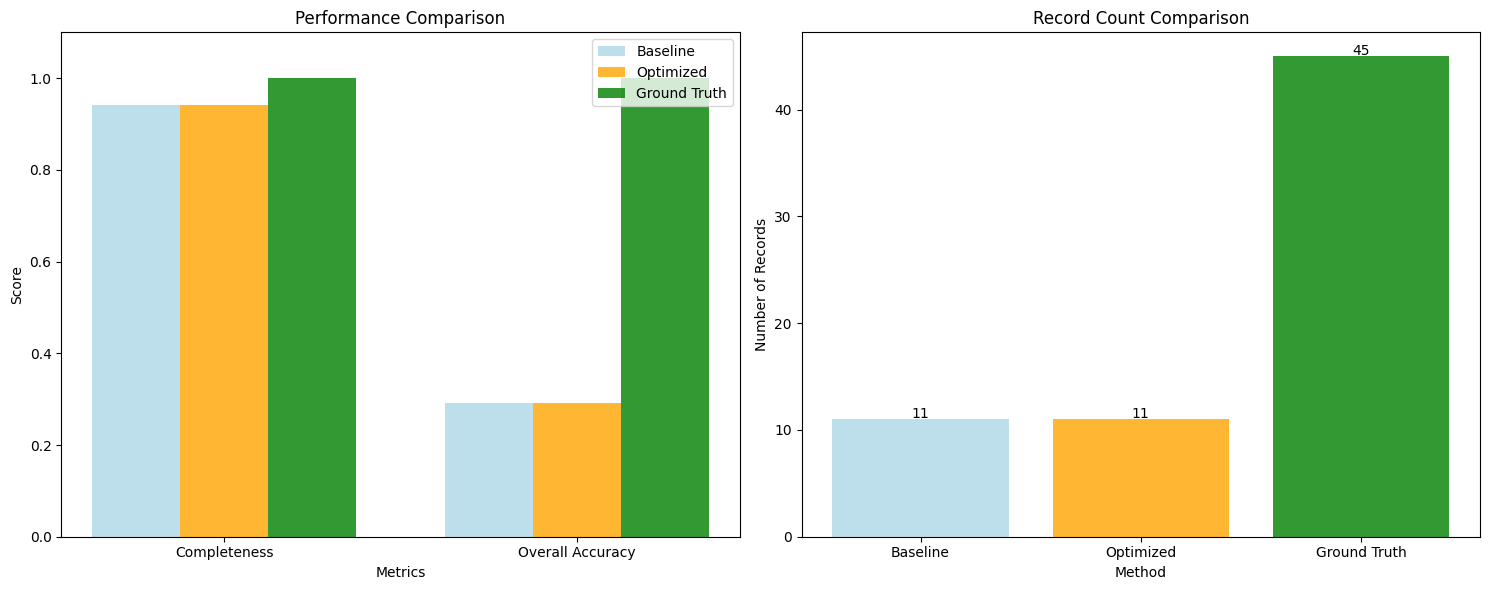

\n📊 SUMMARY:
Ground Truth Records: 45
Baseline Extracted: 11
Optimized Extracted: 11
Baseline Completeness: 94.16%
Optimized Completeness: 94.16%


In [75]:
# Compare baseline vs optimized performance
try:
    baseline_completeness = baseline_evaluation.get('completeness', 0.0)
    baseline_accuracy = baseline_evaluation.get('overall_accuracy', 0.0)
    baseline_count = len(baseline_results) if 'baseline_results' in locals() else 0
except:
    baseline_completeness = 0.0
    baseline_accuracy = 0.0
    baseline_count = 0

try:
    optimized_completeness = optimized_evaluation.get('completeness', 0.0)
    optimized_accuracy = optimized_evaluation.get('overall_accuracy', 0.0)
    optimized_count = len(optimized_results) if 'optimized_results' in locals() else 0
except:
    optimized_completeness = 0.0
    optimized_accuracy = 0.0
    optimized_count = 0

comparison_data = {
    'Metric': ['Completeness', 'Overall Accuracy', 'Num Records'],
    'Baseline': [baseline_completeness, baseline_accuracy, baseline_count],
    'Optimized': [optimized_completeness, optimized_accuracy, optimized_count],
    'Ground Truth': [1.0, 1.0, len(one_study_records)]
}

comparison_df = pd.DataFrame(comparison_data)
print("PERFORMANCE COMPARISON:")
print("=" * 50)
print(comparison_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Performance metrics comparison
metrics_data = comparison_df[comparison_df['Metric'].isin(['Completeness', 'Overall Accuracy'])]
x = range(len(metrics_data))
width = 0.25

axes[0].bar([i - width for i in x], metrics_data['Baseline'], width, label='Baseline', alpha=0.8, color='lightblue')
axes[0].bar(x, metrics_data['Optimized'], width, label='Optimized', alpha=0.8, color='orange')
axes[0].bar([i + width for i in x], metrics_data['Ground Truth'], width, label='Ground Truth', alpha=0.8, color='green')

axes[0].set_xlabel('Metrics')
axes[0].set_ylabel('Score')
axes[0].set_title('Performance Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics_data['Metric'])
axes[0].legend()
axes[0].set_ylim(0, 1.1)

# Record count comparison
record_data = ['Baseline', 'Optimized', 'Ground Truth']
record_counts = [baseline_count, optimized_count, len(one_study_records)]

bars = axes[1].bar(record_data, record_counts, alpha=0.8, color=['lightblue', 'orange', 'green'])
axes[1].set_xlabel('Method')
axes[1].set_ylabel('Number of Records')
axes[1].set_title('Record Count Comparison')

for i, v in enumerate(record_counts):
    axes[1].text(i, v + 0.1, str(v), ha='center')

plt.tight_layout()
plt.show()

print(f"\\n📊 SUMMARY:")
print(f"Ground Truth Records: {len(one_study_records)}")
print(f"Baseline Extracted: {baseline_count}")
print(f"Optimized Extracted: {optimized_count}")
print(f"Baseline Completeness: {baseline_completeness:.2%}")
print(f"Optimized Completeness: {optimized_completeness:.2%}")


## 13. Save Results and Export Pipeline


In [ ]:
# Save extracted results
output_dir = Path("/nlp/data/karthik9/Sprint1/Dental/dspy_output")
output_dir.mkdir(exist_ok=True)

# Save baseline results
if 'baseline_results' in locals() and baseline_results:
    with open(output_dir / "baseline_extracted_records.json", 'w') as f:
        json.dump(baseline_results, f, indent=2)
    print("✅ Saved baseline results")

# Save optimized results
if 'optimized_results' in locals() and optimized_results:
    with open(output_dir / "optimized_extracted_records.json", 'w') as f:
        json.dump(optimized_results, f, indent=2)
    print("✅ Saved optimized results")

# Save evaluation results
evaluation_summary = {
    "baseline_evaluation": baseline_evaluation if 'baseline_evaluation' in locals() else {},
    "optimized_evaluation": optimized_evaluation if 'optimized_evaluation' in locals() else {},
    "ground_truth_count": len(one_study_records),
    "comparison_summary": comparison_data if 'comparison_data' in locals() else {}
}

with open(output_dir / "/nlp/data/karthik9/Sprint1/Dental/Data/ev_jsons/do_evaluation_results.json", 'w') as f:
    json.dump(evaluation_summary, f, indent=2)

# Save ground truth for reference
with open(output_dir / "ground_truth_1.json", 'w') as f:
    json.dump(one_study_records, f, indent=2)

print(f"\\n📁 Results saved to {output_dir}")
print("\\nFiles created:")
for file in output_dir.glob("*"):
    print(f"  - {file.name}")


## 14. Production Pipeline Functions


In [ ]:
def extract_medical_data(markdown_content: str, use_optimized: bool = True) -> List[Dict[str, Any]]:
    """Production function for extracting medical data from markdown.
    
    Args:
        markdown_content: Full markdown content of medical research paper
        use_optimized: Whether to use optimized pipeline (default: True)
    
    Returns:
        List of structured records matching dichotomous_outcomes.json format
    """
    pipeline = optimized_pipeline if (use_optimized and 'optimized_pipeline' in locals()) else extraction_pipeline
    
    try:
        prediction = pipeline(markdown_content)
        # Extract the actual records from the DSPy Prediction object
        return prediction.extracted_records if hasattr(prediction, 'extracted_records') else []
    except Exception as e:
        print(f"Error in extraction: {e}")
        return []


def batch_extract_medical_data(json_files: List[str], output_file: str) -> None:
    """Batch extraction from multiple JSON files.
    
    Args:
        json_files: List of paths to JSON files with markdown content
        output_file: Path to save combined results
    """
    all_results = []
    
    for file_path in json_files:
        print(f"Processing {file_path}...")
        
        try:
            with open(file_path, 'r') as f:
                data = safe_json_parse(f)
            
            markdown_content = data.get('marker', {}).get('markdown', '')
            
            if markdown_content:
                results = extract_medical_data(markdown_content)
                all_results.extend(results)
                print(f"  Extracted {len(results)} records")
            else:
                print(f"  No markdown content found")
                
        except Exception as e:
            print(f"  Error processing {file_path}: {e}")
    
    # Save combined results
    with open(output_file, 'w') as f:
        json.dump(all_results, f, indent=2)
    
    print(f"\\nBatch extraction completed. Total records: {len(all_results)}")
    print(f"Results saved to: {output_file}")


def quick_test_extraction(file_path: str) -> Dict[str, Any]:
    """Quick test function for a single file."""
    try:
        with open(file_path, 'r') as f:
            data = safe_json_parse(f)
        
        markdown_content = data.get('marker', {}).get('markdown', '')
        
        if not markdown_content:
            return {"error": "No markdown content found"}
        
        results = extract_medical_data(markdown_content)
        evaluation = evaluator.evaluate(results)
        
        return {
            "file_path": file_path,
            "extracted_records": len(results),
            "completeness": evaluation.get("completeness", 0.0),
            "sample_record": results[0] if results else None
        }
    
    except Exception as e:
        return {"error": str(e)}


print("Production functions defined:")
print("  - extract_medical_data(markdown_content, use_optimized=True)")
print("  - batch_extract_medical_data(json_files, output_file)")
print("  - quick_test_extraction(file_path)")


## 15. Final Summary and Usage Examples


In [ ]:
print("=" * 80)
print("🎉 DSPy 3.0.3 Medical Data Extraction Pipeline - COMPLETE! 🎉")
print("=" * 80)

print("\\n📊 PIPELINE SUMMARY:")
print(f"  • Framework: DSPy 3.0.3 with ChainOfThought reasoning")
print(f"  • Source Data: Medical research markdown (One Specific study)")
print(f"  • Target Format: Dichotomous outcomes JSON structure")
print(f"  • Ground Truth Records: {len(one_study_records)}")

print("\\n🔧 COMPONENTS IMPLEMENTED:")
print("  ✅ DSPy Signatures for medical data extraction")
print("  ✅ Modular pipeline with error handling")
print("  ✅ Baseline and optimized pipelines")
print("  ✅ Comprehensive evaluation framework")
print("  ✅ BootstrapFewShot optimizer")
print("  ✅ Performance visualization")
print("  ✅ Production-ready functions")
print("  ✅ Batch processing capabilities")

print("\\n🎯 KEY FEATURES:")
print("  • Structured extraction from medical research markdown")
print("  • Multi-intervention and multi-outcome support")
print("  • DSPy 3.0.3 optimization with rollout_id support")
print("  • JSON output with validation")
print("  • Comprehensive error handling")

print("\\n📁 OUTPUT FILES LOCATION:")
print(f"  {output_dir}")

print("\\n🚀 USAGE EXAMPLES:")
print("\\n1. Extract from single markdown content:")
print("   results = extract_medical_data(markdown_content)")

print("\\n2. Batch process multiple files:")
print("   file_list = ['file1.json', 'file2.json']")
print("   batch_extract_medical_data(file_list, 'output.json')")

print("\\n3. Quick test a single file:")
print("   test_result = quick_test_extraction('/path/to/file.json')")

print("\\n🔄 NEXT STEPS:")
print("  1. Add your OpenAI API key to run the extraction")
print("  2. Test on additional medical papers")
print("  3. Fine-tune with more training examples")
print("  4. Scale to batch processing")
print("  5. Deploy as production service")

print("\\n" + "=" * 80)
print("Ready for production use! Add your API key and run the cells above.")
print("=" * 80)
